# Theoretical predictions:

**Sprawdzone i działa na:**

**For state $|1 \rangle$ and $H = - Z \otimes Z$:**
    $$\langle 1 \otimes X \rangle = 0 $$
    $$\langle Z \otimes Z \rangle = 1$$
   
**For state $|1 \rangle$ and $H = 1 \otimes X$:** 
    $$\langle 1 \otimes X \rangle = 0$$
    $$\langle Z \otimes Z \rangle = \cos^{2} \frac{2t}{\hbar}$$


**For state $\frac{|0\rangle + |1 \rangle}{2}$ and $H = 1 \otimes X$:**
    $$\langle 1 \otimes X \rangle = 1 $$
    $$\langle Z \otimes Z \rangle = 0 $$

**For state $\frac{|0\rangle + |1 \rangle}{2}$ and $H = -Z \otimes Z$:**
    $$\langle 1 \otimes X \rangle = \cos^{2} \frac{2t}{\hbar}$$
    $$\langle Z \otimes Z \rangle = 0 $$

# TDVP code

Libraries:

In [5]:
import numpy as np
import scipy.sparse.linalg as ssl
import scipy.linalg as sc
import matplotlib.pyplot as plt

np.set_printoptions(threshold=np.inf)

Global variables:

In [6]:
global J, h, D, d, Dmax
J = 1 #Hamiltonian
h = 0.1 #Hamiltonian
D = 6 #Bond dimension
Dmax = 50
d = 2 #Physical dimension

**Hamiltonian:**

In [7]:
sz = [[1, 0], [0,-1]]
sx = [[0,1], [1,0]]
on = [[1,0], [0,1]]

X1 = np.tensordot(sx, on, axes=([],[]))
X2 = np.tensordot(on, sx, axes=([],[]))
ZZ = np.tensordot(sz, sz, axes=([],[]))
H = -J*ZZ - h*0.5*X1 - h*0.5*X2

I = np.tensordot(on, on, axes=([],[]))

## **MPS:  (Nieważne bo na dole uzyskuje AL, AR, C z A ogólnego)**

In [8]:
AC = np.zeros((D, d, D)).astype(complex)
AR = np.zeros((D, d, D)).astype(complex)
AL = np.zeros((D, d, D)).astype(complex)
C = np.identity(D).astype(complex)

$\rightrightarrows$ state:

In [9]:
#NIE wazne 

AC[0,0,0] = 1/np.sqrt(2)
AC[0,1,0] = 1/np.sqrt(2)

AR[0,0,0] = 1/np.sqrt(2)
AR[0,1,0] = 1/np.sqrt(2)

AL[0,0,0] = 1/np.sqrt(2)
AL[0,1,0] = 1/np.sqrt(2)

$\upuparrows$  state:

In [10]:
AC[0,0,0] = 1
AR[0,0,0] = 1
AL[0,0,0] = 1

## A defining 
### Finding AL, C, AR from A
#### Right-Left Canonical is needed to get proper observables regardless of bond dimension D

In [11]:
A = np.zeros((D, d, D)).astype(complex)

#do testów i symulacji używam tych dwóch stanów:

#state 01/sqrt(2):
A[0,0,0] = 1/np.sqrt(2)
A[0,1,0] = 1/np.sqrt(2)

#state 0:
#A[0,0,0] = 1

<img src="Left.png" width="700">
<img src="Mix.png" width="700">

In [12]:
#Funkcja z A robiaca AL, AR, C 

def leftOrthonormalise(A, mu):
    L = np.random.rand(D,D)
    L = np.divide( L, np.linalg.norm(L) )
    Lold = L
    al, L = np.linalg.qr( np.reshape( np.tensordot(L, A, axes=([1], [0])), (D*d, D)) )
    if np.array_equal(L, -1*Lold):
        al = -1*al #fixing positive sign with singular value
        L = -1*L
    lamb = np.linalg.norm(L)
    L = np.divide(L, lamb)
    delta = np.linalg.norm( np.subtract(L, Lold) )

    while delta > mu:
        #Tu jest jakies przyspieszenie z Arnoldim ale go nie rozumie, a nie jeskt kluczowe
        _, L = np.linalg.qr(L)
        L = np.divide( L, np.linalg.norm(L) )
        Lold = L
        al, L = np.linalg.qr( np.reshape( np.tensordot(L, A, axes=([1], [0])), (D*d, D)) )
        if np.array_equal(L, -1*Lold):
            al = -1*al
            L = -1*L
        lamb = np.linalg.norm(L)
        L = np.divide( L, lamb )
        delta = np.linalg.norm( np.subtract(L, Lold) )
    
    al = np.reshape(al, (D,d,D))
    return al, L, lamb

def rightOrthonormalise(A, mu):
    C = np.random.rand(D,D)
    C = C/np.linalg.norm(C)
    Cold = C  
    ar, C = np.linalg.qr( np.transpose( np.reshape( np.tensordot(A, C, axes=([2], [0])), (D, d*D)) ) )
    if np.array_equal(C, -1*Cold):
        ar = -1*np.transpose(ar) #fixing positive sign
        C = -1*np.transpose(C)
    lamb = np.linalg.norm(C)
    C = np.divide(C, lamb)
    delta = np.linalg.norm( np.subtract(C, Cold) )
    
    while delta > mu:
        _, C = np.linalg.qr(np.transpose(C))
        C = np.transpose(C)
        C = np.divide( C, np.linalg.norm(C) )
        Cold = C
        ar, C = np.linalg.qr( np.transpose( np.reshape( np.tensordot(A, C, axes=([2], [0])), (D, d*D)) ) )
        if np.array_equal(C, -1*Cold):
            ar = -1*np.transpose(ar) #fixing positive sign
            C = -1*np.transpose(C)
        lamb = np.linalg.norm(C)
        C = np.divide( C, lamb )

        delta = np.linalg.norm( np.subtract(C, Cold) )
    
    ar = np.reshape(ar, (D,d,D))
    return ar, C, lamb

def mixedCanonical(A, mu = 10e-10):
    AL, _,lamb = leftOrthonormalise(A, mu) 
    AR, C, _ = rightOrthonormalise(AL, mu)
    U, C, V = np.linalg.svd(C)   #moze wziac dagger z V?
    
    AL = np.reshape(np.dot(np.reshape(AL,(d*D,D)),U), (D,d*D))
    AL = np.reshape(np.array(np.dot(np.matrix(U).getH(), AL)), (D,d,D))
    
    AR = np.reshape(np.dot(np.reshape(AR,(d*D,D)),V), (D,d*D))
    AR = np.reshape(np.array(np.dot(np.matrix(V).getH(), AR)), (D,d,D))

    return AL, AR, np.diag(C), lamb

In [13]:
AL, AR, C, _ = mixedCanonical(A)

*Calculating observables - contracting and Hamiltonian normalization*

In [14]:
def contractHamiltonian(al, c, ar, HH):
    AA = np.tensordot(al, c, axes=([2], [0]))
    AA = np.tensordot(AA, ar, axes=([2], [0]))
    O = np.tensordot(AA, HH, axes=([1,2], [0,2]))
    O = np.tensordot(np.conjugate(AA), O, axes=([0,3,1,2], [0,1,2,3]))
    cc = np.asscalar(np.tensordot(c, np.conjugate(c), axes=([0,1], [0,1])))
    return np.asscalar(O)/cc

def normalizeHamiltonian(al, c, ar, HH):
    EH = contractHamiltonian(al, c, ar, HH)
    HH = HH - EH*I
    return HH

### Finding G1 and G2:

![title](LH.png)

![title](G1.png)

In [15]:
def buildLH(al, HH):
    EL = np.tensordot(al, np.conjugate(al), axes=([1],[1]))
    III = np.tensordot(np.identity(D),np.identity(D), axes=([],[]))
    EL = III - EL
    EL = np.reshape(np.swapaxes(EL, 1,2), (D*D, D*D))
    EL = np.reshape(sc.pinv(EL, rcond=1e-14), (D,D,D,D))
    
    AA = np.tensordot(al, al, axes=([2], [0]))
    O = np.tensordot(AA, HH, axes=([1,2], [0,2]))
    O = np.tensordot(O, np.conjugate(AA), axes=([0,2,3], [0,1,2]))
    
    LH = np.tensordot(O, EL, axes=([0,1],[0,1]))
    
    return LH

def buildRH(ar, HH):
    ER = np.tensordot(ar, np.conjugate(ar), axes=([1],[1]))
    III = np.tensordot(np.identity(D),np.identity(D), axes=([],[]))
    ER = III - ER
    ER = np.reshape(np.swapaxes(ER, 1,2), (D*D, D*D))
    ER = np.reshape(sc.pinv(ER, rcond=1e-14), (D,D,D,D))
    
    AA = np.tensordot(ar, ar, axes=([2], [0]))
    O = np.tensordot(AA, HH, axes=([1,2], [0,2]))
    O = np.tensordot(O, np.conjugate(AA), axes=([1,2,3], [3,1,2]))
    
    RH = np.tensordot(O, ER, axes=([0,1],[2,3]))
    
    return RH

def buildG(al, ar, HH):
    LH = buildLH(al, HH)
    RH = buildRH(ar, HH)
    
    IID = np.identity(D)
    IId = np.identity(d)
    
    #MAKE G1:
    
    LHII = np.tensordot(LH, IId, axes=([],[]))
    LHII = np.tensordot(LHII, IID, axes=([],[]))
    LHII = np.swapaxes(np.swapaxes( np.swapaxes(LHII, 1,2), 2,4), 4,3)
    
    IIRH = np.tensordot(IID, IId, axes=([],[]))
    IIRH = np.tensordot(IIRH, RH, axes=([],[]))
    IIRH = np.swapaxes(np.swapaxes( np.swapaxes(IIRH, 1,2), 2,4), 4,3)
    
    a = np.tensordot(al,HH, axes=([1],[0]))
    a = np.tensordot(a, np.conjugate(al), axes=([0,2],[0,1]))
    a = np.swapaxes(a, 2,3)
    ALHI = np.tensordot(a, IID, axes=([],[]))
    ALHI = np.swapaxes(np.swapaxes(ALHI, 2,4), 3,4)
    
    b = np.tensordot(ar,HH, axes=([1],[2]))
    b = np.tensordot(b, np.conjugate(ar), axes=([1,4],[2,1]))
    b = np.swapaxes(b, 0,1)
    IHAR = np.tensordot( IID, b, axes=([],[]))
    IHAR = np.swapaxes(np.swapaxes(IHAR, 1,2), 2,3)
    
    G1 = LHII + IIRH + ALHI + IHAR
    
    #MAKE G2:
    
    LHII2 = np.tensordot(LH, al, axes=([0],[0]))
    LHII2 = np.tensordot(LHII2, np.conjugate(al), axes=([0,1],[0,1]) )
    LHII2 = np.tensordot(LHII2, IID, axes=([],[]) )
    LHII2 = np.swapaxes(LHII2, 1,2)
    
    IIRH2 = np.tensordot(al, np.conjugate(al), axes=([0,1],[0,1]))
    IIRH2 = np.tensordot(IIRH2, RH, axes=([],[]))
    IIRH2 = np.swapaxes(IIRH2, 1,2)
    
    a = np.tensordot(al, al, axes=([2], [0]))                     
    aa = np.tensordot(a, HH, axes=([1,2], [0,2]))                  
    ALHI2 = np.tensordot(aa, np.conjugate(a), axes=([0,2,3], [0,1,2]))
    ALHI2 = np.tensordot(ALHI2, IID, axes=([],[]))
    ALHI2 = np.swapaxes(ALHI2, 1,2)
                         
    b = np.tensordot(al,HH, axes=([1],[0]))
    b = np.tensordot(b,ar, axes=([3],[1]))
    b = np.tensordot(b, np.conjugate(al), axes=([0,2],[0,1]))
    IHAR2 = np.tensordot(b, np.conjugate(ar), axes=([1,3],[1,2]))                     
    
    G2 = LHII2 + IIRH2 + ALHI2 + IHAR2
    
    return G1, G2

### Finding AL, AR:

<img src="alar.png" width="600">

In [16]:
def findALAR(AC, C):
    ULA, PLA = sc.polar( np.reshape(AC,(d*D, D)), side='left')
    ULC, PLC = sc.polar(C, side='left')
    
    al = np.array( np.dot(ULA, np.matrix(ULC).getH()) ) 
    
    URA, PRA = sc.polar( np.reshape(AC, (D,d*D)), side='right')
    URC, PRC = sc.polar(C, side='right')
    
    ar = np.array( np.dot(np.matrix(URC).getH(), URA) )
    
    al = np.reshape(al, (D,d,D))
    ar = np.reshape(ar, (D,d,D))
    return al, ar

### Increasing D while executing:

In [24]:
def increaseD(al, c, ar, HH, dt):
    global D
    ds = 1e-8
    
    #Build projection operator
    III = np.swapaxes(np.tensordot(np.identity(D),np.identity(d), axes=([],[])), 1,2)
    TL = np.tensordot(al, np.conjugate(al), axes=([2],[2]))
    TR = np.swapaxes( np.swapaxes( np.tensordot(np.conjugate(ar), ar, axes=([0],[0])), 0,1 ), 2,3)
    PL = III - TL
    PR = III - TR

    #Evolve Hamiltonian
    HH = np.reshape( np.swapaxes(HH, 1,2), (d*d, d*d))
    EH = sc.expm(-1j*dt*HH)
    EH = np.reshape(EH, (d,d,d,d))
    
    #Contract and make SVD
    a = np.tensordot(al, c, axes=([2],[0]))
    a = np.tensordot(a, ar, axes=([2],[0]))
    a = np.tensordot(a, EH, axes=([1,2],[0,1]))
    a = np.tensordot(PL, a, axes=([2,3],[0,2]))
    a = np.tensordot(a, PR, axes=([2,3],[0,1]))
    a = np.reshape(a, (D*d, D*d))
    
    U, S, V = np.linalg.svd(a) 
    
    
    i = 0
    AL0 = []
    AL1 = []
    AR0 = []
    AR1 = []
    while(S[i] > ds and Dmax > D + i):
        u = np.reshape(U[:,i], (D,d))
        v = np.reshape(V[:,i], (D,d))
        
        #Czy to dobrze sklada...
        AL0.extend(u[:,0])
        AL1.extend(u[:,1])
        AR0.extend(v[:,0])
        AR1.extend(v[:,1])
        
        i = i + 1
    
    #Create bigger matrixes with vectors
    if i > 0:
        print("Dodane i: ",i)
        bigAR = np.zeros((D+i, d, D+i)).astype(complex)
        bigAR[0:D, :, 0:D] = ar
        bigAL = np.zeros((D+i, d, D+i)).astype(complex)
        bigAL[0:D, :, 0:D] = al
        
        #Czy to dziala dobrze..
        bigAL[0:D, 0, D:D+i] = np.reshape(AL0, (D, i))
        bigAL[0:D, 1, D:D+i] = np.reshape(AL1, (D, i))
        
        bigAR[D:D+i, 0, 0:D] = np.conjugate( np.transpose( np.reshape(AR0, (D, i)) ))
        bigAR[D:D+i, 1, 0:D] = np.conjugate( np.transpose( np.reshape(AR1, (D, i)) ))
        
        bigC = np.zeros((D+i, D+i)).astype(complex)
        bigC[0:D, 0:D] = c
        c = bigC
        
        D = D + i
        al = bigAL
        ar = bigAR
    
    return al, c, ar

## TDVP algorithm:

<img src="algo.png" width="700">

In [18]:
outcomesX = []
outcomesZ = []
outcomesH = []
timing = []

In [19]:
def tdvp(al, c, ar, HH):
    dt = 0.01
    time = 100
    #Normowac Hamiltonian do sredniej zera z każdą petlą?
    
    outcomesX.clear()
    outcomesZ.clear()
    outcomesH.clear()
    timing.clear()
    
    #HH = normalizeHamiltonian(al, c, ar, HH)
    for i in range(time):
        #print(i)
        G1, G2 = buildG(al, ar, HH)
        G1 = np.reshape(G1, (D*d*D, D*d*D))
        G2 = np.reshape(G2, (D*D, D*D))
        
        AC = np.reshape( np.tensordot(al, c, axes=([2],[0]) ), (D*d*D,1) )
        c = np.reshape(c, (D*D, 1))
        
        #Pade approximation so D^3
        AC = np.dot( sc.expm(-1j*dt*G1), AC)
        c = np.dot( sc.expm(-1j*dt*G2), c)

        AC = np.reshape(AC, (D,d,D))
        c = np.reshape(c, (D,D))
        
        al, ar = findALAR(AC,c)
        
        outcomesX.append( contractHamiltonian(al, c, ar, X1)) 
        outcomesZ.append( contractHamiltonian(al, c, ar, ZZ))
        outcomesH.append( contractHamiltonian(al, c, ar, H) )
        timing.append(i*dt)
        
        #Powiększenie D wymiaru  #Na razie opcjonalne
        #if D < Dmax:
         #   al, c, ar = increaseD(al, c, ar, HH, dt)
        #print("Actualne D: ", D)
        
    return al, c, ar, outcomesX, outcomesZ, outcomesH, timing

# **Main:**

In [20]:
AL, C, AR, _, _, _ , _= tdvp(AL, C, AR, H)

**OBSERWABLA 1X w czasie:**

/home/justyna/anaconda3/envs/datascience/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


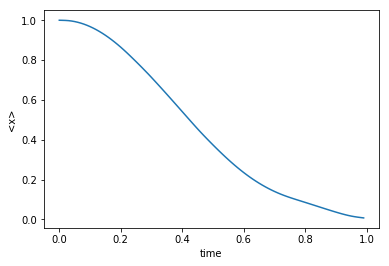

In [21]:
plt.plot(timing, outcomesX)
plt.xlabel('time')
plt.ylabel('<x>')
plt.show()

**OBSERWABLA ZZ w czasie:**

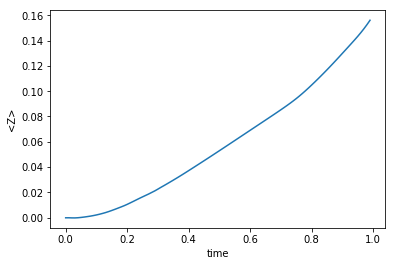

In [22]:
plt.plot(timing, outcomesZ)
plt.xlabel('time')
plt.ylabel('<Z>')
plt.show()

**OBSERWABLA H w czasie:**

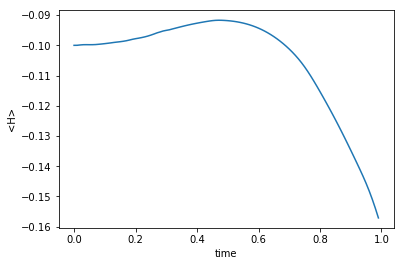

In [23]:
plt.plot(timing, outcomesH)
plt.xlabel('time')
plt.ylabel('<H>')
plt.show()

## Code to get results for different D:

In [222]:
def getPlots(HH):
    global D
    listX = []
    listZ = []
    listH = []
    
    for DD in range(2,14,2):
        D = DD
        print(D)

        A = np.zeros((D, d, D)).astype(complex)
        A[0,0,0] = 1/np.sqrt(2)
        A[0,1,0] = 1/np.sqrt(2)
        
        al, ar, c, _ = mixedCanonical(A)
    
        _, _, _, ox, oz, oh, t = tdvp(al, c, ar, HH)
        
        listX.append(ox[:])
        listZ.append(oz[:])
        listH.append(oh[:])
        
    return listX, listZ, listH, t   

In [91]:
LX, LZ, LH, T = getPlots(H)

2
4
6
8
10
12


**X Observable for many**

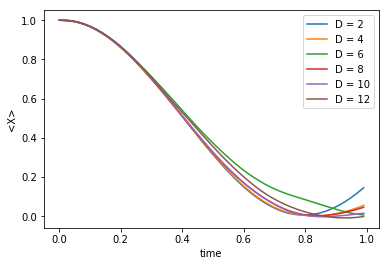

In [92]:
plt.plot(T, LX[0], label='D = 2')
plt.plot(T, LX[1], label='D = 4')
plt.plot(T, LX[2], label='D = 6')
plt.plot(T, LX[3], label='D = 8')
plt.plot(T, LX[4], label='D = 10')
plt.plot(T, LX[5], label='D = 12')
#plt.plot(T, LX[6], label='D = 14')
plt.legend()
plt.xlabel('time')
plt.ylabel('<X>')
plt.show()

**ZZ Observable for many**

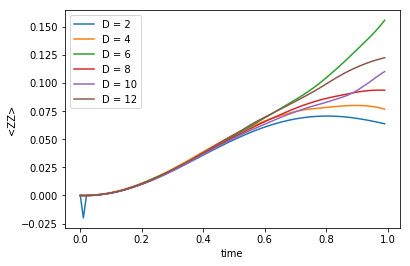

In [93]:
plt.plot(T, LZ[0], label='D = 2')
plt.plot(T, LZ[1], label='D = 4')
plt.plot(T, LZ[2], label='D = 6')
plt.plot(T, LZ[3], label='D = 8')
plt.plot(T, LZ[4], label='D = 10')
plt.plot(T, LZ[5], label='D = 12')
#plt.plot(T, LZ[6], label='D = 14')
plt.legend()
plt.xlabel('time')
plt.ylabel('<ZZ>')
plt.show()

**H Observable for many**

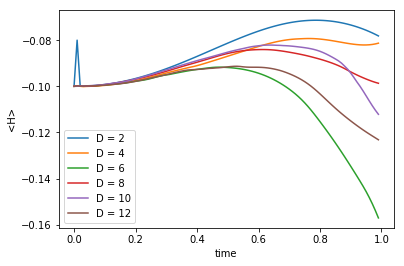

In [94]:
plt.plot(T, LH[0], label='D = 2')
plt.plot(T, LH[1], label='D = 4')
plt.plot(T, LH[2], label='D = 6')
plt.plot(T, LH[3], label='D = 8')
plt.plot(T, LH[4], label='D = 10')
plt.plot(T, LH[5], label='D = 12')
#plt.plot(T, LH[6], label='D = 14')
plt.legend()
plt.xlabel('time')
plt.ylabel('<H>')
plt.show()